Epoch [1/200] | Loss D: 0.4366 | Loss G: 6.4900
Epoch [2/200] | Loss D: 0.4090 | Loss G: 9.0635
Epoch [3/200] | Loss D: 0.7739 | Loss G: 4.6145
Epoch [4/200] | Loss D: 0.7805 | Loss G: 8.7631
Epoch [5/200] | Loss D: 0.5761 | Loss G: 6.9093
Epoch [6/200] | Loss D: 0.5207 | Loss G: 5.7881
Epoch [7/200] | Loss D: 0.4092 | Loss G: 5.2676
Epoch [8/200] | Loss D: 0.4834 | Loss G: 4.7226
Epoch [9/200] | Loss D: 0.4061 | Loss G: 4.2559
Epoch [10/200] | Loss D: 0.5097 | Loss G: 5.1015
Epoch [11/200] | Loss D: 0.6115 | Loss G: 7.8711
Epoch [12/200] | Loss D: 1.2342 | Loss G: 10.1759
Epoch [13/200] | Loss D: 0.4757 | Loss G: 6.6372
Epoch [14/200] | Loss D: 2.1389 | Loss G: 1.0114
Epoch [15/200] | Loss D: 0.4012 | Loss G: 4.8763
Epoch [16/200] | Loss D: 0.3818 | Loss G: 3.9924
Epoch [17/200] | Loss D: 0.4375 | Loss G: 5.9442
Epoch [18/200] | Loss D: 1.0715 | Loss G: 0.7444
Epoch [19/200] | Loss D: 0.8273 | Loss G: 3.2727
Epoch [20/200] | Loss D: 0.4159 | Loss G: 4.1866
Epoch [21/200] | Loss D: 0.4

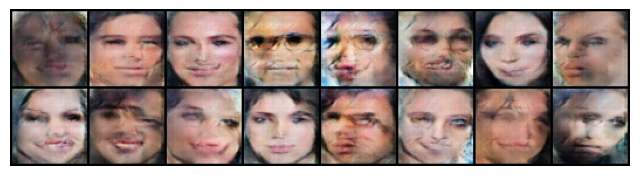

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import os

# Hyperparameters
image_size = 64
batch_size = 128
latent_dim = 100
num_epochs = 200
lr = 0.0002
beta1 = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Preprocessing
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = torchvision.datasets.ImageFolder(root="./dataset", transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Generator Model (DCGAN)
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.generator = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.generator(x)

# **Improved Discriminator Model**
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x).view(-1, 1)

# Initialize models
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Loss & Optimizers
criterion = nn.BCELoss()
optimizerG = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerD = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

# Training Loop
for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(dataloader):
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        # Labels with smoothing
        real_labels = torch.full((batch_size, 1), 0.9, device=device)  # Smooth real labels
        fake_labels = torch.zeros(batch_size, 1, device=device)

        # Train Discriminator
        outputs = discriminator(real_images)
        lossD_real = criterion(outputs, real_labels)

        noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        fake_images = generator(noise)

        outputs = discriminator(fake_images.detach())
        lossD_fake = criterion(outputs, fake_labels)

        lossD = lossD_real + lossD_fake
        optimizerD.zero_grad()
        lossD.backward()
        optimizerD.step()

        # Train Generator
        outputs = discriminator(fake_images)
        lossG = criterion(outputs, real_labels)  # Want fake images to be classified as real
        optimizerG.zero_grad()
        lossG.backward()
        optimizerG.step()

    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss D: {lossD.item():.4f} | Loss G: {lossG.item():.4f}")

    if (epoch + 1) % 5 == 0:
        with torch.no_grad():
            fake_images = generator(noise).cpu()
        vutils.save_image(fake_images, f'generated_faces_epoch_{epoch+1}.png', normalize=True)

# Generate & Show Images
noise = torch.randn(16, latent_dim, 1, 1, device=device)
fake_images = generator(noise).cpu()
grid = vutils.make_grid(fake_images, normalize=True)
plt.figure(figsize=(8, 8))
plt.imshow(grid.permute(1, 2, 0).detach().numpy())
plt.axis('off')
plt.show()
